inspired by: https://github.com/qbxlvnf11/conditional-GAN/blob/main/conditional-GAN-generating-fashion-mnist.ipynb  
modified from: https://realpython.com/generative-adversarial-networks/

In [1]:
!source gan_venv/bin/activate

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.manual_seed(111)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [5]:
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

In [6]:
# subset of the data - smaller for my CPU 
subset_indices = torch.arange(9600) # must be divisable by batch size 32
train_set      = Subset(train_set, subset_indices)

In [7]:
batch_size = 32
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True # Drops last batch if smaller than batch_size
)

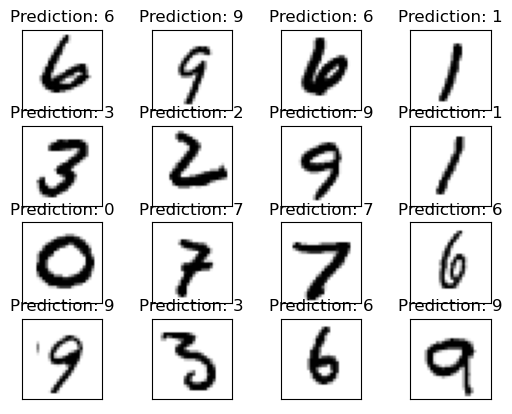

In [8]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.title("Prediction: {}".format(mnist_labels[i]))
    plt.xticks([])
    plt.yticks([])

In [9]:
28 * 28

784

## Conditional GANs

In [10]:
class Discriminator(nn.Module):
    def __init__(self, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, class_num) # 10, 10

        self.model = nn.Sequential(
            nn.Linear(784 + class_num, 1024), # 28 x 28 = 784; + class_num 10
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784) # reshape 
        labels = labels.long().squeeze()
        c = self.label_emb(labels) # one-hot vector to embedding vector 
        x = torch.cat([x, c], 1)   # concat image and label
        output = self.model(x)
        return output

In [11]:
discriminator = Discriminator(class_num=10)

In [12]:
class Generator(nn.Module):
    def __init__(self, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, class_num) # 10, 10

        self.model = nn.Sequential(
            nn.Linear(100 + class_num, 256),    # 100-dimension input + 10
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),   # 748-dimension output - to be organised into 28 x 28
            nn.Tanh(),              # output between -1 and 1
        )

    def forward(self, x, labels):
        labels = labels.long().squeeze()
        c = self.label_emb(labels) # one-hot vector to embedding vector 
        x = torch.cat([x, c], 1)   # concat image and label 
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [13]:
generator = Generator(class_num=10)

## Setup hyperparameters

In [26]:
# Training
num_epochs    = 50  # Train epochs
learning_rate = 1e-4

In [27]:
# Loss function
loss_function = nn.BCELoss()

# Optimizer
g_optimizer   = torch.optim.Adam(generator.parameters(),     lr=learning_rate)
d_optimizer   = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [28]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples         = real_samples
        real_samples_labels  = torch.ones((batch_size, 1))      # 1 for real training data
        real_sample_classes   = mnist_labels

        latent_space_samples     = torch.randn((batch_size, 100))                  # intial random data to generate from d
        generated_class_labels   = torch.randint(0, 10, (batch_size, 1)).squeeze() # intial random data to call the classes
        generated_samples_labels = torch.zeros((batch_size, 1))                    # 0 for synthetic generated samples
        generated_samples        = generator(latent_space_samples, labels=generated_class_labels)  # generate samples

        all_samples        = torch.cat((real_samples,        generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        all_class_labels   = torch.cat((real_sample_classes, generated_class_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, labels=all_class_labels)
        loss_discriminator   = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        d_optimizer.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100))

        # Training the generator
        generator.zero_grad()
        generated_samples              = generator(latent_space_samples, labels=generated_class_labels)
        output_discriminator_generated = discriminator(generated_samples, labels=generated_class_labels)
        loss_generator                 = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        g_optimizer.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 50.0
Epoch: 0 Loss G.: 0.0
Epoch: 1 Loss D.: 50.0
Epoch: 1 Loss G.: 0.0
Epoch: 2 Loss D.: 50.0
Epoch: 2 Loss G.: 0.0
Epoch: 3 Loss D.: 50.0
Epoch: 3 Loss G.: 0.0
Epoch: 4 Loss D.: 50.0
Epoch: 4 Loss G.: 0.0
Epoch: 5 Loss D.: 50.0
Epoch: 5 Loss G.: 0.0
Epoch: 6 Loss D.: 50.0
Epoch: 6 Loss G.: 0.0
Epoch: 7 Loss D.: 50.0
Epoch: 7 Loss G.: 0.0
Epoch: 8 Loss D.: 50.0
Epoch: 8 Loss G.: 0.0
Epoch: 9 Loss D.: 50.0
Epoch: 9 Loss G.: 0.0
Epoch: 10 Loss D.: 50.0
Epoch: 10 Loss G.: 0.0
Epoch: 11 Loss D.: 50.0
Epoch: 11 Loss G.: 0.0
Epoch: 12 Loss D.: 50.0
Epoch: 12 Loss G.: 0.0
Epoch: 13 Loss D.: 50.0
Epoch: 13 Loss G.: 0.0
Epoch: 14 Loss D.: 50.0
Epoch: 14 Loss G.: 0.0
Epoch: 15 Loss D.: 50.0
Epoch: 15 Loss G.: 0.0
Epoch: 16 Loss D.: 50.0
Epoch: 16 Loss G.: 0.0
Epoch: 17 Loss D.: 50.0
Epoch: 17 Loss G.: 0.0
Epoch: 18 Loss D.: 50.0
Epoch: 18 Loss G.: 0.0
Epoch: 19 Loss D.: 50.0
Epoch: 19 Loss G.: 0.0
Epoch: 20 Loss D.: 50.0
Epoch: 20 Loss G.: 0.0
Epoch: 21 Loss D.: 50.0
Epoch: 21

## Use the trained generator

In [29]:
latent_space_samples     = torch.randn((batch_size, 100))                  # intial random data to generate from d
generated_class_labels   = torch.randint(0, 10, (batch_size, 1)).squeeze() # intial random data to call the classes
generated_samples        = generator(latent_space_samples, labels=generated_class_labels)

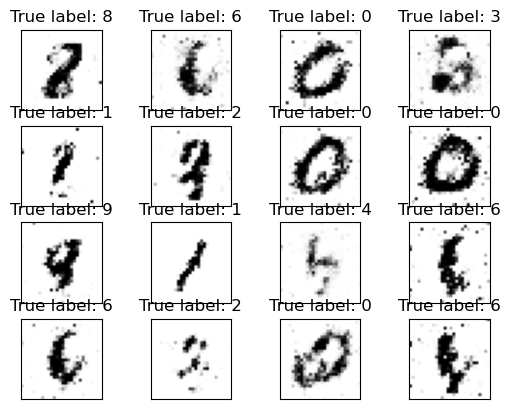

In [30]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.title("True label: {}".format(generated_class_labels[i]))
    plt.xticks([])
    plt.yticks([])